<a href="https://colab.research.google.com/github/ach4l/CovIndia_analysis/blob/master/Vadodara_Covid_Fraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecting Fraud in Reporting Covid 19 Cases

In this notebook, we will develop a test to figure out if the number of Covid-19 cases being reported are being manipulated. To be sure, this test will not be able to find **ALL** instances of manipulation, but it is still powerful enough to find many such instances.

To illustrate the approach, I will use Vadodara, Gujarat as an example. We will then apply the test to all districts and States in India to find out who has been manipulating their data.

The source for all data is https://covid19india.org who provide reliable district-level data for India.

In [1]:
# Some customary Python Imports

import requests        # Needs to be installed (pip install requests)
import json
import pandas as pd    # Needs to be installed (pip install pandas)
import numpy           # Needs to be installed (pip install numpy)

In [2]:
# To get district wise daily data, we use the districts_daily API

url = 'https://api.covid19india.org/districts_daily.json'
raw_data = requests.get(url=url).json()
print(raw_data['districtsDaily']['Gujarat'].keys())

dict_keys(['Ahmadabad', 'Anand', 'Aravalli', 'Banas Kantha', 'Bharuch', 'Bhavnagar', 'Botad', 'Chota Udaipur', 'Dahod', 'Gandhinagar', 'Gir Somnath', 'Jamnagar', 'Kachchh', 'Kheda', 'Mahesana', 'Mahisagar', 'Morbi', 'Narmada', 'Navsari', 'Panch Mahals', 'Patan', 'Porbandar', 'Rajkot', 'Sabar Kantha', 'Surat', 'Tapi', 'Vadodara', 'Valsad', 'Dang', 'Surendranagar', 'Unknown', 'Ahmedabad', 'Banaskantha', 'Chhota Udaipur', 'Kutch', 'Mehsana', 'Panchmahal', 'Sabarkantha', 'Devbhumi Dwarka', 'Junagadh', 'Other State', 'Amreli'])


In [3]:
# We extract Vadodara daily data. Note that this data is cumulative!

vadodara_data = raw_data['districtsDaily']['Gujarat']['Vadodara']
print(vadodara_data)

[{'active': 199, 'confirmed': 199, 'deceased': 0, 'recovered': 0, 'date': '2020-04-21'}, {'notes': '', 'active': 190, 'confirmed': 208, 'deceased': 10, 'recovered': 8, 'date': '2020-04-22'}, {'notes': '', 'active': 154, 'confirmed': 218, 'deceased': 11, 'recovered': 53, 'date': '2020-04-23'}, {'notes': '', 'active': 159, 'confirmed': 223, 'deceased': 11, 'recovered': 53, 'date': '2020-04-24'}, {'notes': '', 'active': 162, 'confirmed': 230, 'deceased': 12, 'recovered': 56, 'date': '2020-04-25'}, {'notes': '', 'active': 166, 'confirmed': 234, 'deceased': 12, 'recovered': 56, 'date': '2020-04-26'}, {'notes': '', 'active': 171, 'confirmed': 240, 'deceased': 13, 'recovered': 56, 'date': '2020-04-27'}, {'notes': '', 'active': 184, 'confirmed': 255, 'deceased': 13, 'recovered': 58, 'date': '2020-04-28'}, {'notes': '', 'active': 167, 'confirmed': 270, 'deceased': 16, 'recovered': 87, 'date': '2020-04-29'}, {'notes': '', 'active': 185, 'confirmed': 289, 'deceased': 17, 'recovered': 87, 'date': 

In [4]:
# We want to extract only the confirmed cases for our analysis

cumulative_cases = []
for date in vadodara_data:
  that_day = date['confirmed']
  cumulative_cases.append(that_day)
print(cumulative_cases)

[199, 208, 218, 223, 230, 234, 240, 255, 270, 289, 308, 325, 350, 385, 405, 421, 440, 465, 493, 518, 547, 574, 592, 605, 620, 639, 660, 682, 700, 726, 750, 771, 806, 836, 854, 885, 914, 947, 981, 1009, 1043, 1074, 1106, 1140, 1179, 1224, 1258, 1293, 1328, 1360, 1395, 1434, 1471, 1511, 1553, 1597, 1638, 1682, 1725, 1770, 1813, 1854, 1898, 1940, 1985, 2029, 2074, 2121, 2165, 2165]


In [5]:
# We are interested in NEW daily cases for our analysis

daily_cases = [j-i for i, j in zip(cumulative_cases[:-1], cumulative_cases[1:])]
print(daily_cases)

[9, 10, 5, 7, 4, 6, 15, 15, 19, 19, 17, 25, 35, 20, 16, 19, 25, 28, 25, 29, 27, 18, 13, 15, 19, 21, 22, 18, 26, 24, 21, 35, 30, 18, 31, 29, 33, 34, 28, 34, 31, 32, 34, 39, 45, 34, 35, 35, 32, 35, 39, 37, 40, 42, 44, 41, 44, 43, 45, 43, 41, 44, 42, 45, 44, 45, 47, 44, 0]


In [6]:
# Lets look at only last 30 days numbers for now

last_30_days = daily_cases[-31:-1]
print(last_30_days)

[28, 34, 31, 32, 34, 39, 45, 34, 35, 35, 32, 35, 39, 37, 40, 42, 44, 41, 44, 43, 45, 43, 41, 44, 42, 45, 44, 45, 47, 44]


# Analysis

The basic idea is this: Imagine tossing coins for 10 times. If it is a fair coin, you would expect it to (mostly) return around 5 heads and 5 tails. But when you actually do the experiment, you see that it doesnt give 5 heads **all the time**. Sometimes it might give 4 heads and sometimes 6. It might also give 3 or 7 heads in some batches.

One might wonder, how many times will it give 5 heads or 4 heads 7 heads? The answer to this question is in the following graph.

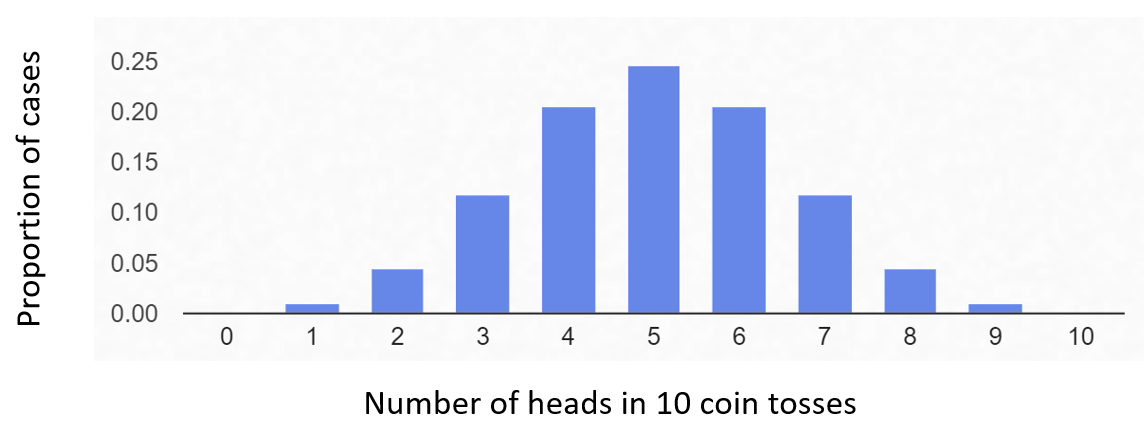

This is what is known as a **Binomial Distribution**. As you can see, unsurprisingly, 5 heads is the most likely outcome. But 4 heads or 6 heads are not so unlikely with a healthy 20% chance each!

Now imagine you had asked your friend to do this experiment (of counting how many heads in 10 tosses) a 100 times. Later you asked him to report what he found. Your friend was too lazy to actually do such a stupid experiment. But he knew 5 heads was the most likely outcome. So he told you most of the times it was 5 heads. When pressed more he said 80% of the times it was 5 heads, and sometimes 4 heads and sometimes 6 heads.

But you knew that this was too good to be true! he should have gotten4 heads and 6 heads more number of times and he was **clearly lying!** We are essentially going to find out the lazy lies being told to us by various agencies using a similar reasoning.

Now as you see with the Vadodara data, the number of covid positive cases being reported in the last 30 days is remarkably stable. For argument's sake, lets assume there are 500 tests done in Vadodara everyday, and about 10 percent of them turn out to be positive. How many positive cases we should expect everyday? Well, this is again the same problem as coin tosses, so let us look at Binomial Distribution for this problem.

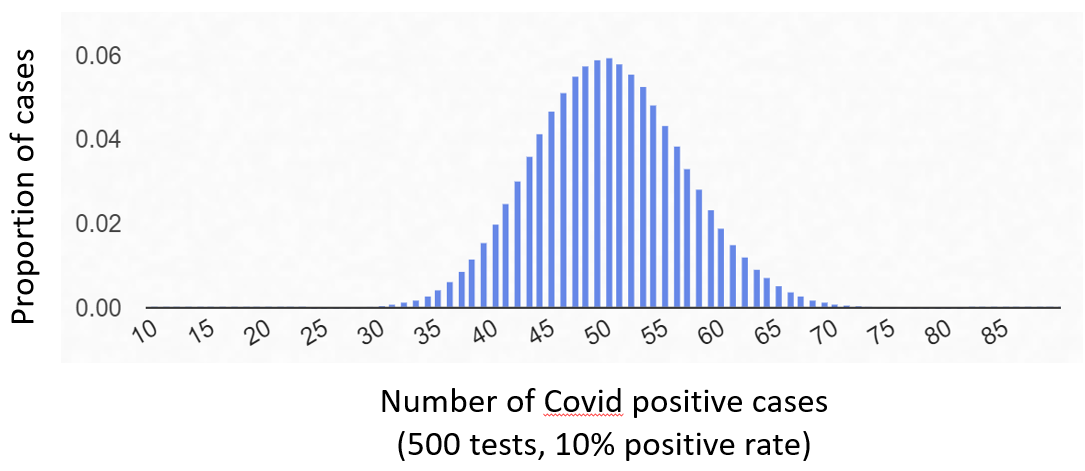

Unsurprisingly, 50 cases is the most likely outcome. However, there is a good amount of spread, i.e. it is decently probable that 45 cases or 55 cases might be reported on a given day. But if you look at Vadodara data, it is remarkably stable. This is the equivalent of your lazy friend reporting 5 heads most of the times. It is too good to be true!

In the following analysis, we will use standard deviation (a way of quantifying the spread in the data) to find out **exactly** what is the probability of such a thing happening. In other words, how certain are we that the authorities are lying!

In [7]:
# Finding the standard deviation for all 5 consecutive days

window_size = 5 # You can play around with this parameter to see how the results are affected

last_30_days_pd = pd.Series(data=last_30_days)
rolling_std = last_30_days_pd.rolling(window=window_size).std()
print(rolling_std)

0          NaN
1          NaN
2          NaN
3          NaN
4     2.489980
5     3.082207
6     5.805170
7     5.263079
8     4.722288
9     4.560702
10    5.069517
11    1.303840
12    2.489980
13    2.607681
14    3.209361
15    2.701851
16    2.701851
17    2.588436
18    1.788854
19    1.303840
20    1.516575
21    1.483240
22    1.483240
23    1.483240
24    1.581139
25    1.581139
26    1.643168
27    1.224745
28    1.816590
29    1.224745
dtype: float64


What are the chances of the standard deviation being so low? One easy way to find out is to generate many random set of 5 values from the binomial distribution and counting how many sets of 5 values actually have a spread smaller than what is reported by the authorities.

**NOTE - we are assuming that the number of tests and test positive rate remains fairly constant over a period of 5 days**

If those values change drastically over the period of 5 days, the spread in the data should be even more! This is because the mean, which is the most expected value, itself will change drastically if number of tests or positivity rate changes in those 5 days. The mean, for clarity, is the total number of tests * proportion of tests which are positive.

In [8]:
# Looking at only last 5 days. Average is 45 and assuming 10% positive rate

random_binomial = numpy.random.binomial(n=450, p=0.1, size=(10000,window_size))


In [17]:
# Calculating the standard deviation for each set of 5 values
std_random = numpy.std(random_binomial, axis=1)

# Finding the number of values lesser than the standard deviation reported by authorities (Only Last 5 days)
lesser_values = std_random < rolling_std[(len(rolling_std)-1)]
number_of_lesser_values = len(std_random[lesser_values])
print("Only " + str(number_of_lesser_values/100) + " % of instances where standard deviation was less than what was reported by authorities")


Only 0.37 % of instances where standard deviation was less than what was reported by authorities


## Conclusion for Vadodara

There is only **0.37 % chance** of the cases being reported to have such a less spread. This is just for the last 5 days! This trend has been true for about 10 such 5-day windows in the past two weeks. This makes it highly improbable, and we can be certain that the authorities are just making up those numbers!

# Finding all such cities and states

I hope this gives you a simple way to find if your city, state or country might be fudging their data. Please let me know **achal.agrawal.1987[at]gmail.com** if you find something interesting or have some doubts.

